In [25]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lifelines.utils import to_long_format
from scipy.signal import savgol_filter
from scipy import stats
from scipy.stats import chi2_contingency


In [26]:
watch=pd.read_excel('graph.xlsx',sheet_name=0)
pats=pd.read_excel('graph.xlsx',sheet_name=1)
outcome=pats[['PatientID','Depression Diagnosed During Study']]
outcome.columns=['PatientID','depression']

pats=pats.rename(columns={'Date Of MDD Diagnosis':'date'})
pats.date=pd.to_datetime(pats.date)
watch.DateTested=pd.to_datetime(watch.DateTested)
date=pats[['PatientID','date']]
watch=watch.merge(date, on='PatientID', how='left')
watch.date.fillna('2021-12-31',inplace=True)
watch.date=pd.to_datetime(watch.date)
watch=watch.loc[watch.DateTested<watch.date]

yesnodic={'yes':1,'no':0}
outcome=outcome.replace(yesnodic)
watch_rel=['PatientID',  'SleepTime', 'SPSleepTime', 'DeepSleep%', 'LightSleep%', 'pREM%', 'PAI', 'PAI-1', 'PAI-2', 'PAI-3', 'PAI-4', 'MeanPulserate', 'MaxPulserate', 'SleepLatency(min)', 'REMpLatency(min)', 'SleepEfficiency', 'NumberOfWakes']
watch_d=watch[watch_rel]

pat_thres=5
drop=True
if drop:
    gropued=watch_d.groupby('PatientID').count()
    good_pats=gropued.loc[gropued.SleepTime>pat_thres].index




## WATCH DATA

FUNCTIONS

In [27]:
def drop_thresh(ser, thresh):
       return ser.loc[ser<thresh]

def last(ser):
    return (ser.iloc[-1])

def trend(ser):
    z = np.polyfit(range(len(ser)),ser,1)
    return z[0]*10

def count_thresh(ser, thres):
    return (ser.loc[ser<thres].count())/len(ser)

def first_under_thres(ser,thresh):
    ser=ser.reset_index(drop=True)
    count_thresh=ser.loc[ser<60].count()
    if count_thresh==0:
        return 1
    else:
        index=next(i for i,v in enumerate(ser) if (v<thresh))
        return index/len(ser)

def thresh(ser,thres):
    count_thresh=ser.loc[ser<60].count()
    if count_thresh==0:
        return 0
    else:
        return 1
    
def thresh_month(ser,thres,weeks):
    ser=ser[-weeks:]
    count_thresh=ser.loc[ser<60].count()
    if count_thresh==0:
        return 0
    else:
        return 1
    
def  mean_month(ser, weeks):
    ser=ser[-weeks:]
    return ser.mean()

In [28]:
ser=watch_d.loc[watch_d.PatientID=='RDS01']['REMpLatency(min)']
thresh=40


GROUPBY

In [29]:
drop=True
if drop:
    watch_d=watch_d.loc[watch_d['REMpLatency(min)']<200]

In [30]:
weeks=3

data=watch_d.groupby('PatientID').agg({
    'MeanPulserate':[lambda x: last(x),                                                  
                    lambda x:mean_month(x, weeks)
                    ],
    'LightSleep%':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks)],
                    
    'pREM%':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks),
                    ],
     'PAI':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks),
                    ],
      'PAI':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks),
                    ],
     'MeanPulserate':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks),
                    ],   
     'SleepEfficiency':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks)
                    ],
     'NumberOfWakes':[lambda x: last(x),                                                  
                    lambda x:mean_month(x,weeks),
                    ],                                  
                 
    'REMpLatency(min)': [lambda x:last(x),
                         lambda x:mean_month(x,weeks),                                          
                        lambda x:thresh_month(x,60,4),

                        ]
                        }).reset_index()

In [31]:
data.columns = data.columns.map('_'.join).str.strip('|')



In [32]:
data.columns=[name.replace('<lambda_0>','last') for name in data.columns]
data.columns=[name.replace('<lambda_1>','mean') for name in data.columns]
data.columns=[name.replace('<lambda_2>','thresh_bool') for name in data.columns]

data.columns=[name.replace('PatientID_','PatientID') for name in data.columns]
data.columns=[name.replace('REMpLatency(min)','REM_lat') for name in data.columns]

TABLE WITH WATCH DATA

In [33]:
data

,PatientID,MeanPulserate_last,MeanPulserate_mean,LightSleep%_last,LightSleep%_mean,pREM%_last,pREM%_mean,PAI_last,PAI_mean,SleepEfficiency_last,SleepEfficiency_mean,NumberOfWakes_last,NumberOfWakes_mean,REM_lat_last,REM_lat_mean,REM_lat_thresh_bool
0,RDS01,55,61.000000,42.140,52.544000,31.570,25.563000,79.3,58.666667,89.62,90.583333,3,4.000000,85,75.000000,1
1,RDS02,70,70.000000,92.577,89.184667,7.415,5.876667,33.7,30.200000,70.97,75.790000,4,5.666667,44,54.333333,1
2,RDS03,91,86.666667,59.546,62.371667,21.545,22.047667,25.9,23.833333,83.55,83.463333,2,5.000000,139,124.333333,0
3,RDS04,66,68.333333,64.608,75.546000,24.580,16.187000,18.9,24.200000,86.54,84.283333,11,8.333333,85,93.333333,0
4,RDS08,63,61.666667,39.730,42.855000,33.456,31.909000,76.1,76.166667,91.32,90.233333,3,5.666667,89,121.666667,0
5,RDS09,47,45.000000,53.532,60.609000,24.499,21.578333,44.0,30.033333,82.65,83.456667,7,6.333333,123,98.666667,0
6,RDS10,69,68.000000,42.506,53.548333,34.178,29.039000,41.6,36.266667,85.77,83.566667,6,8.000000,49,98.666667,1
7,RDS11,55,56.000000,48.912,59.436333,34.205,20.917667,45.0,34.500000,89.69,83.200000,5,8.000000,113,109.666667,0
8,RDS12,67,67.000000,55.034,58.450667,28.520,25.274333,32.3,37.633333,83.34,84.043333,14,10.666667,60,65.000000,1
9,RDS13,43,43.333333,56.333,58.987000,26.713,24.653667,13.5,17.800000,85.87,87.006667,7,6.666667,79,116.666667,0


### DEMOG DATA

In [34]:
yesnodic={'yes':1,'no':0}
sexdic={'Female':1,'Male':0}
pats.replace(yesnodic,inplace=True)
pats.replace(sexdic,inplace=True)

In [35]:
rel_cols=['PatientID', 'Sex','Age','new OSA Diagnosed During Study', 'BZD', 'SSRI', 'SNRI', 'SGA', 'FGA',
          'NBZD', 'Lithium', 'NaSSA', 'TCA', 'Depalept', 'Lamotrigine', 'DNRI',           
          'Depression Diagnosed During Study', 'Bipolar Depression', 'Dysthimia', 
          'Cognitive Disorder', 'Panic Disorder','NUMBER OF PRIOR mdd EPISODES']
pat_d=pats[rel_cols]
pat_d=pat_d.rename(columns={'new OSA Diagnosed During Study':'OSA',
                            'Depression Diagnosed During Study':'Depression',
                            'NUMBER OF PRIOR mdd EPISODES':'mdd_episodes'
                      })
              

In [36]:
pat_d.drop('FGA', axis=1, inplace=True)

TABLE WITH DEMGORAPHOC DATA

In [37]:
pat_d

,PatientID,Sex,Age,OSA,BZD,SSRI,SNRI,SGA,NBZD,Lithium,NaSSA,TCA,Depalept,Lamotrigine,DNRI,Depression,Bipolar Depression,Dysthimia,Cognitive Disorder,Panic Disorder,mdd_episodes
0,RDS01,0,39,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,RDS02,1,59,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,4
2,RDS03,1,54,0,1,1,0,1,0,0,1,0,0,0,1,1,0,0,0,0,9
3,RDS04,1,53,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,6
4,RDS08,0,64,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5
5,RDS09,1,62,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,3
6,RDS10,1,57,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,4
7,RDS11,1,62,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,3
8,RDS12,0,49,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,3
9,RDS13,0,62,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,2


## ALL PATIENT ANALYSIS

## MERGE

In [38]:
merged=data.merge(pat_d, on='PatientID')
merged.shape

(20, 36)

## UNIVARIATE

In [16]:
## compare 3 VS clean (3 vs 7)
## keep the shit
## use only last 2 weeks and 3 weeks
## tables, time graph plots, heatmaps, boxplot

In [17]:
merged.set_index('PatientID', drop=True, inplace=True)

X=merged.drop('Depression', axis=1)
y=merged['Depression']

cat_cols=['Sex','OSA', 'BZD', 'SSRI', 'SNRI', 'SGA',  'NBZD', 'Lithium', 'NaSSA',
          'TCA', 'Depalept', 'Lamotrigine', 'DNRI', 'Bipolar Depression', 
          'Cognitive Disorder', 'Panic Disorder','REM_lat_thresh_bool']
con_vars=list(np.setdiff1d(X.columns,cat_cols))

CONTINOUS

In [18]:
output = pd.DataFrame()


for var in con_vars:
    depres=merged.loc[merged.Depression==1][var]
    control=merged.loc[merged.Depression==0][var]
    d_mean=depres.mean().round(2)
    d_std=depres.std().round(2)
    c_mean=control.mean().round(2)
    c_std=control.std().round(2)
    pval=stats.ttest_ind(depres,control)[1].round(3)
    results={'variable':var,'depression':f'{d_mean}({d_std})','control':f'{c_mean}({c_std})','p_val':pval}
    output = output.append(results, ignore_index=True)

output.sort_values('p_val').reset_index()

,index,variable,depression,control,p_val
0,14,mdd_episodes,6.17(2.04),3.71(1.86),0.017
1,3,LightSleep%_mean,69.61(13.09),60.28(7.43),0.056
2,15,pREM%_last,19.8(9.2),26.56(5.58),0.056
3,2,LightSleep%_last,67.11(16.73),56.03(8.99),0.067
4,4,MeanPulserate_last,70.17(13.29),62.21(10.22),0.161
5,13,SleepEfficiency_mean,83.11(4.14),85.97(4.05),0.168
6,16,pREM%_mean,18.55(7.71),22.5(4.71),0.173
7,5,MeanPulserate_mean,69.5(11.69),62.55(9.51),0.178
8,9,PAI_mean,32.06(7.98),42.31(20.67),0.260
9,8,PAI_last,34.47(10.26),45.64(26.21),0.331


CATEGORICALTCA

In [19]:
output = pd.DataFrame()


for var in cat_cols:
    ct=pd.crosstab(merged[var], merged.Depression)
    print (ct)
    pval=chi2_contingency(ct)[1].round(2)
    dep=round(ct.iloc[1,1]/(ct.iloc[1,1]+ct.iloc[0,1]),2)
    con=round(ct.iloc[1,0]/(ct.iloc[1,0]+ct.iloc[0,0]).round(2),2)
    results={'variable':var,'depression':f'{dep}','control':f'{con}','p_val':pval}
    output = output.append(results, ignore_index=True)

output.columns=['variable', 'depression (perecent positive)','control(percent positive)','p_val']
output.sort_values('p_val')

Depression  0  1
Sex             
0           8  0
1           6  6
Depression   0  1
OSA              
0           12  5
1            2  1
Depression   0  1
BZD              
0            4  3
1           10  3
Depression   0  1
SSRI             
0           10  1
1            4  5
Depression  0  1
SNRI            
0           9  6
1           5  0
Depression  0  1
SGA             
0           9  3
1           5  3
Depression   0  1
NBZD             
0           13  5
1            1  1
Depression   0  1
Lithium          
0           11  5
1            3  1
Depression   0  1
NaSSA            
0           13  4
1            1  2
Depression   0  1
TCA              
0           14  5
1            0  1
Depression   0  1
Depalept         
0           13  6
1            1  0
Depression    0  1
Lamotrigine       
0            13  6
1             1  0
Depression   0  1
DNRI             
0           13  5
1            1  1
Depression           0  1
Bipolar Depression       
0                   

,variable,depression (perecent positive),control(percent positive),p_val
0,Sex,1.0,0.43,0.06
3,SSRI,0.83,0.29,0.08
4,SNRI,0.0,0.36,0.26
16,REM_lat_thresh_bool,0.67,0.29,0.27
8,NaSSA,0.33,0.07,0.41
13,Bipolar Depression,0.0,0.21,0.58
9,TCA,0.17,0.0,0.65
2,BZD,0.5,0.71,0.68
5,SGA,0.5,0.36,0.92
1,OSA,0.17,0.14,1.00


## PLOTTINg

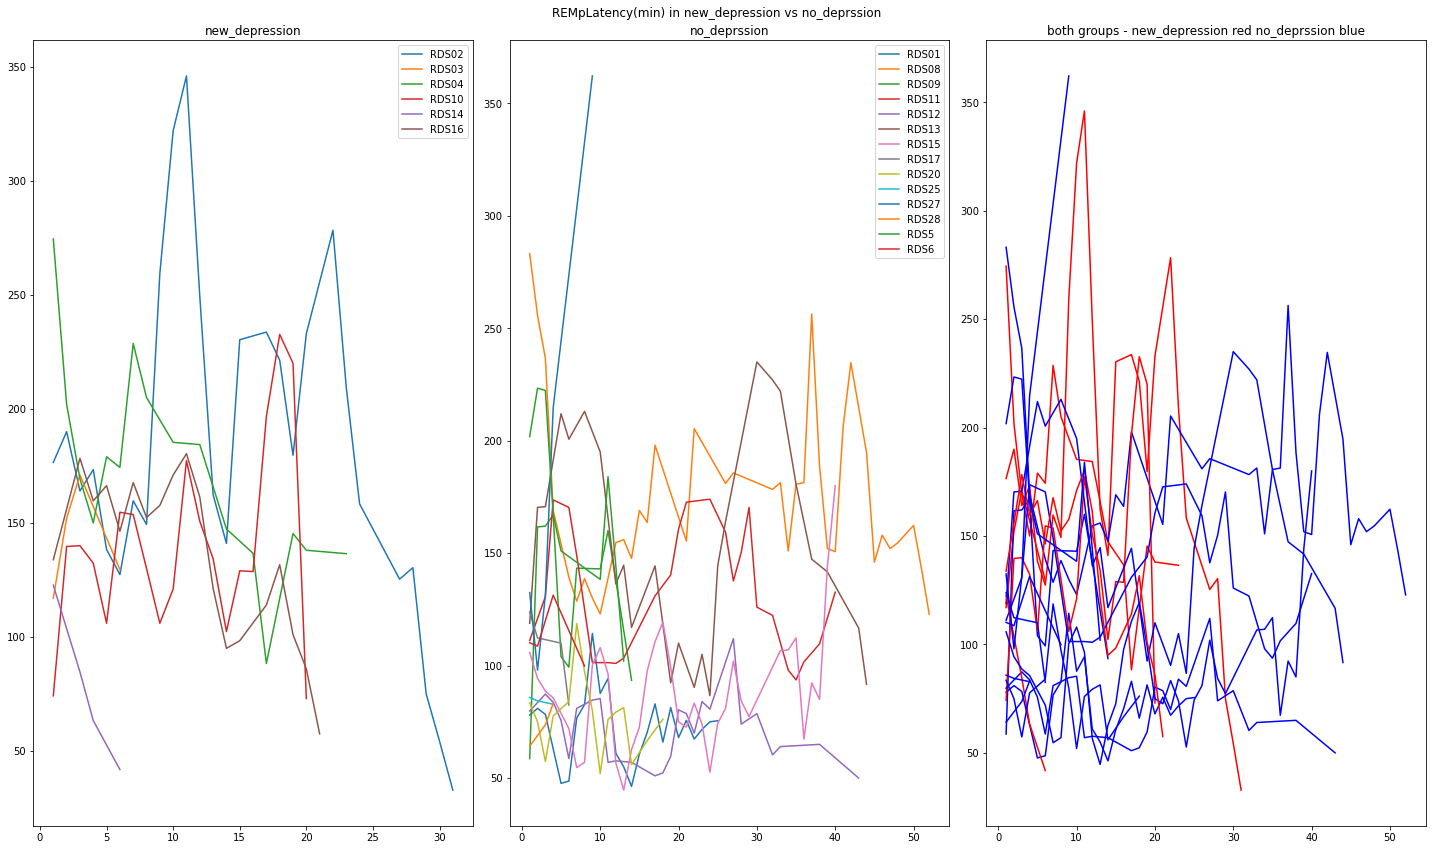

In [22]:
all_pats=list(outcome.PatientID)
new_depression=list(outcome.loc[outcome.depression==1].PatientID)
no_deprssion= list(np.setdiff1d(all_pats,new_depression))


dysthimic=pats.loc[pats.Dysthimia=='yes'].PatientID
bipolar=pats.loc[pats['Bipolar Depression']=='yes'].PatientID
sick=list(new_depression)+list(dysthimic)+list(bipolar)
clean = list(np.setdiff1d(all_pats,sick))

pat='RDS08'
var='REMpLatency(min)'
group1=new_depression
group1_name='new_depression'

group2=no_deprssion
group2_name='no_deprssion'

data=watch_d

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,12))

for pat in all_pats:
    data=watch.loc[watch.PatientID==pat]
    if pat in group1:
        x=data.WeeksInStudy
        y=data[var]
        
        yhat = savgol_filter(y, 3, 1) # window size 51, polynomial order 3
        ax1.plot(x,yhat)
        ax3.plot(x,yhat,color='r')
    elif pat in group2:
        x=data.WeeksInStudy
        y=data[var]
        yhat = savgol_filter(y, 3, 1) # window size 51, polynomial order 3

        ax2.plot(x,yhat)
        ax3.plot(x,yhat,color='b') 

    else:
        pass
    
ax1.set_title(group1_name)
ax1.legend(group1)
ax2.set_title(group2_name)
ax2.legend(group2)

ax3.set_title(f'both groups - {group1_name} red {group2_name} blue')
fig.suptitle(f'{var} in {group1_name} vs {group2_name}')

plt.tight_layout()
plt.show()

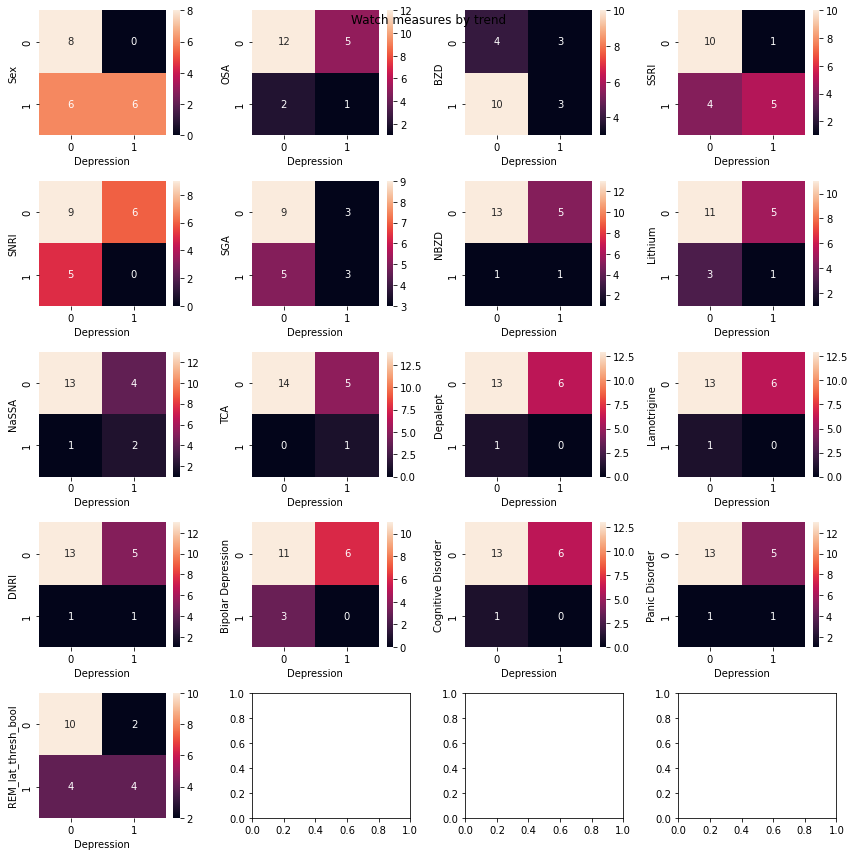

In [23]:
fig, axs = plt.subplots(5,4, figsize=(12,12))


for i,ax in enumerate(axs.flat):

    if i<17:
        col=cat_cols[i]
    
        ct=pd.crosstab(merged[col], merged.Depression)
        sns.heatmap(ct,annot=True,ax=ax)
    else:
        pass
    # Show the result
plt.tight_layout()
fig.suptitle('Watch measures by trend')
plt.show()

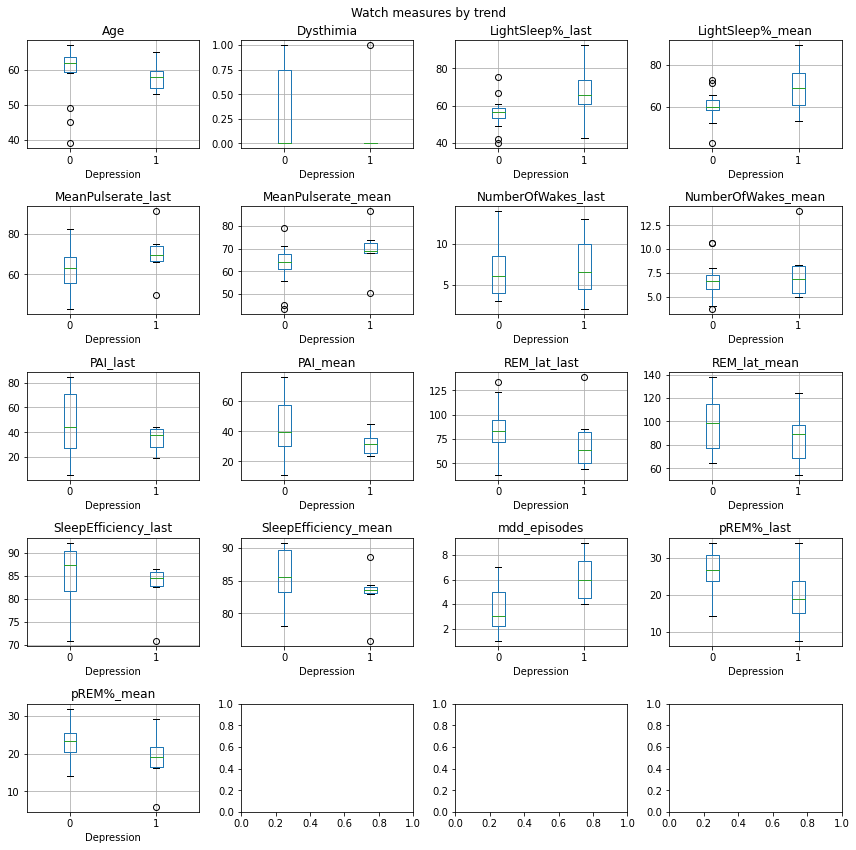

In [24]:

fig, axs = plt.subplots(5,4, figsize=(12,12))


for i,ax in enumerate(axs.flat):
    if i<17:
        col=con_vars[i]
        merged.boxplot(column = [col], # specify columns you wish to analyze
               by = 'Depression',            # specify column by which you wish to group data
               vert = True,        # specify whethere you want vertical or horizontal output
               figsize = (8, 8),
                  ax=ax)   # specify the size of your output
    else:
        pass
    # Show the result
plt.tight_layout()
fig.suptitle('Watch measures by trend')
plt.show()

## CLEAN VS SELECTED DEPRESS ANALYSIS

In [39]:
merged=data.merge(pat_d, on='PatientID')


depres=['RDS02','RDS10','RDS14']
clean=[ 'RDS08','RDS13','RDS15','RDS17','RDS27','RDS28','RDS5']
alli=depres+clean
merged=merged.loc[merged.PatientID.isin(alli)]
merged.shape



(10, 36)

In [40]:
merged.set_index('PatientID', drop=True, inplace=True)

X=merged.drop('Depression', axis=1)
y=merged['Depression']

cat_cols=['Sex','OSA', 'BZD', 'SSRI', 'SNRI', 'SGA',  'Lithium', 'NaSSA',
          'TCA', 'Lamotrigine',  
          'Cognitive Disorder', 'Panic Disorder','REM_lat_thresh_bool']
con_vars=list(np.setdiff1d(X.columns,cat_cols))

## UNITARIATE

In [41]:
output = pd.DataFrame()


for var in con_vars:
    depres=merged.loc[merged.Depression==1][var]
    control=merged.loc[merged.Depression==0][var]
    d_mean=depres.mean().round(2)
    d_std=depres.std().round(2)
    c_mean=control.mean().round(2)
    c_std=control.std().round(2)
    pval=stats.ttest_ind(depres,control)[1].round(3)
    results={'variable':var,'depression':f'{d_mean}({d_std})','control':f'{c_mean}({c_std})','p_val':pval}
    output = output.append(results, ignore_index=True)

output.sort_values('p_val').reset_index()

,index,variable,depression,control,p_val
0,0,Age,58.67(1.53),63.57(2.99),0.030
1,15,REM_lat_mean,72.11(23.43),106.14(22.17),0.060
2,14,REM_lat_last,48.67(4.51),74.43(20.34),0.069
3,17,SleepEfficiency_mean,82.66(6.47),87.42(3.75),0.172
4,16,SleepEfficiency_last,80.79(8.5),86.39(5.96),0.260
5,18,mdd_episodes,5.33(2.31),3.71(1.98),0.289
6,19,pREM%_last,18.81(13.82),25.47(6.88),0.321
7,6,LightSleep%_mean,67.78(18.87),59.43(8.75),0.347
8,20,pREM%_mean,18.67(11.77),23.6(4.94),0.355
9,13,PAI_mean,33.11(3.04),44.88(21.73),0.393


In [42]:
output = pd.DataFrame()


for var in cat_cols:
    ct=pd.crosstab(merged[var], merged.Depression)
    print (ct)
    pval=chi2_contingency(ct)[1].round(2)
    dep=round(ct.iloc[1,1]/(ct.iloc[1,1]+ct.iloc[0,1]),2)
    con=round(ct.iloc[1,0]/(ct.iloc[1,0]+ct.iloc[0,0]).round(2),2)
    results={'variable':var,'depression':f'{dep}','control':f'{con}','p_val':pval}
    output = output.append(results, ignore_index=True)

output.columns=['variable', 'depression (perecent positive)','control(percent positive)','p_val']
output.sort_values('p_val')

Depression  0  1
Sex             
0           5  0
1           2  3
Depression  0  1
OSA             
0           5  2
1           2  1
Depression  0  1
BZD             
0           1  2
1           6  1
Depression  0  1
SSRI            
0           4  1
1           3  2
Depression  0  1
SNRI            
0           4  3
1           3  0
Depression  0  1
SGA             
0           6  1
1           1  2
Depression  0  1
Lithium         
0           5  2
1           2  1
Depression  0  1
NaSSA           
0           7  2
1           0  1
Depression  0  1
TCA             
0           7  2
1           0  1
Depression   0  1
Lamotrigine      
0            6  3
1            1  0
Depression          0  1
Cognitive Disorder      
0                   6  3
1                   1  0
Depression      0  1
Panic Disorder      
0               6  3
1               1  0
Depression           0  1
REM_lat_thresh_bool      
0                    6  0
1                    1  3


,variable,depression (perecent positive),control(percent positive),p_val
12,REM_lat_thresh_bool,1.0,0.14,0.07
0,Sex,1.0,0.29,0.17
2,BZD,0.33,0.86,0.37
5,SGA,0.67,0.14,0.37
4,SNRI,0.0,0.43,0.55
7,NaSSA,0.33,0.0,0.65
8,TCA,0.33,0.0,0.65
1,OSA,0.33,0.29,1.00
3,SSRI,0.67,0.43,1.00
6,Lithium,0.33,0.29,1.00


## PLOTTING

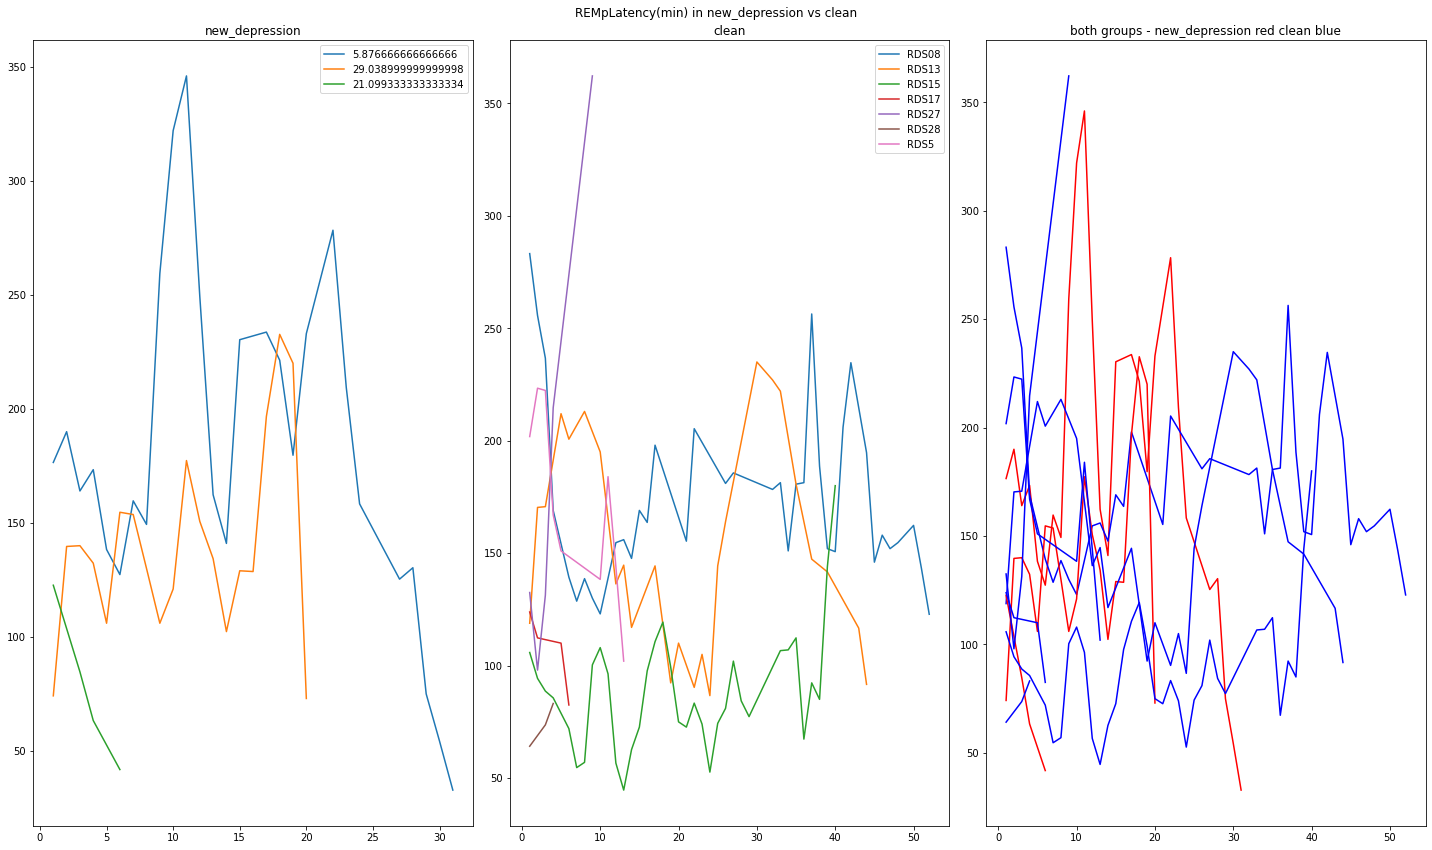

In [43]:

pat='RDS08'
var='REMpLatency(min)'
group1=depres
group1_name='new_depression'

group2=clean
group2_name='clean'

data=watch_d

fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20,12))

for pat in all_pats:
    data=watch.loc[watch.PatientID==pat]
    if pat in group1:
        x=data.WeeksInStudy
        y=data[var]
        
        yhat = savgol_filter(y, 3, 1) # window size 51, polynomial order 3
        ax1.plot(x,yhat)
        ax3.plot(x,yhat,color='r')
    elif pat in group2:
        x=data.WeeksInStudy
        y=data[var]
        yhat = savgol_filter(y, 3, 1) # window size 51, polynomial order 3

        ax2.plot(x,yhat)
        ax3.plot(x,yhat,color='b') 

    else:
        pass
    
ax1.set_title(group1_name)
ax1.legend(group1)
ax2.set_title(group2_name)
ax2.legend(group2)

ax3.set_title(f'both groups - {group1_name} red {group2_name} blue')
fig.suptitle(f'{var} in {group1_name} vs {group2_name}')

plt.tight_layout()
plt.show()

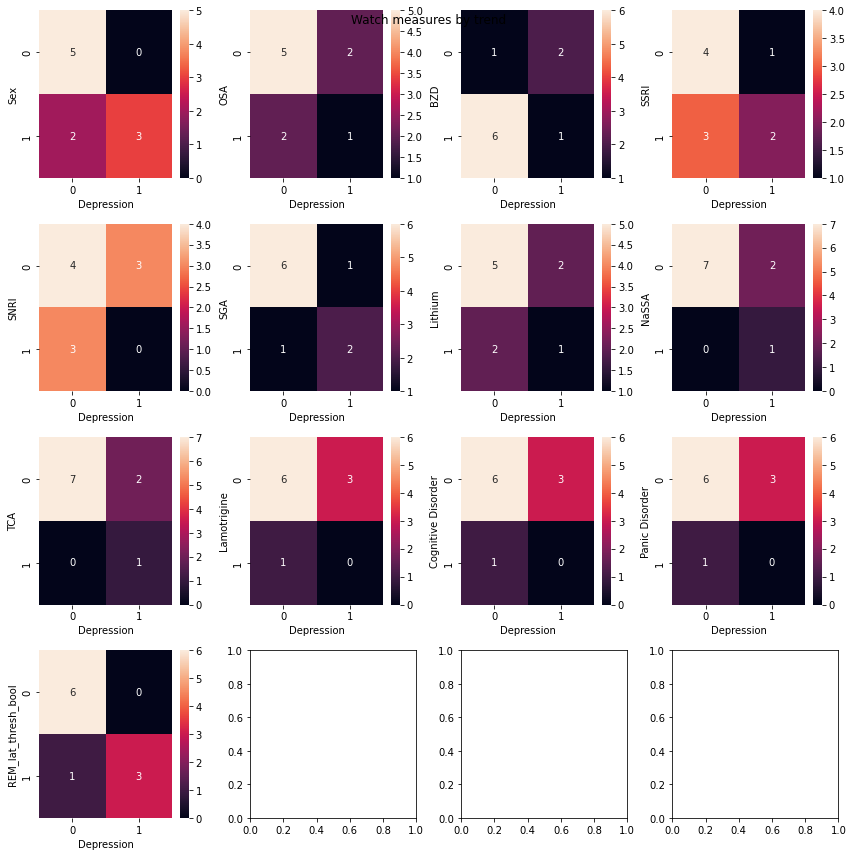

In [44]:
fig, axs = plt.subplots(4,4, figsize=(12,12))


for i,ax in enumerate(axs.flat):

    if i<13:
        col=cat_cols[i]
    
        ct=pd.crosstab(merged[col], merged.Depression)
        sns.heatmap(ct,annot=True,ax=ax)
    else:
        pass
    # Show the result
plt.tight_layout()
fig.suptitle('Watch measures by trend')
plt.show()

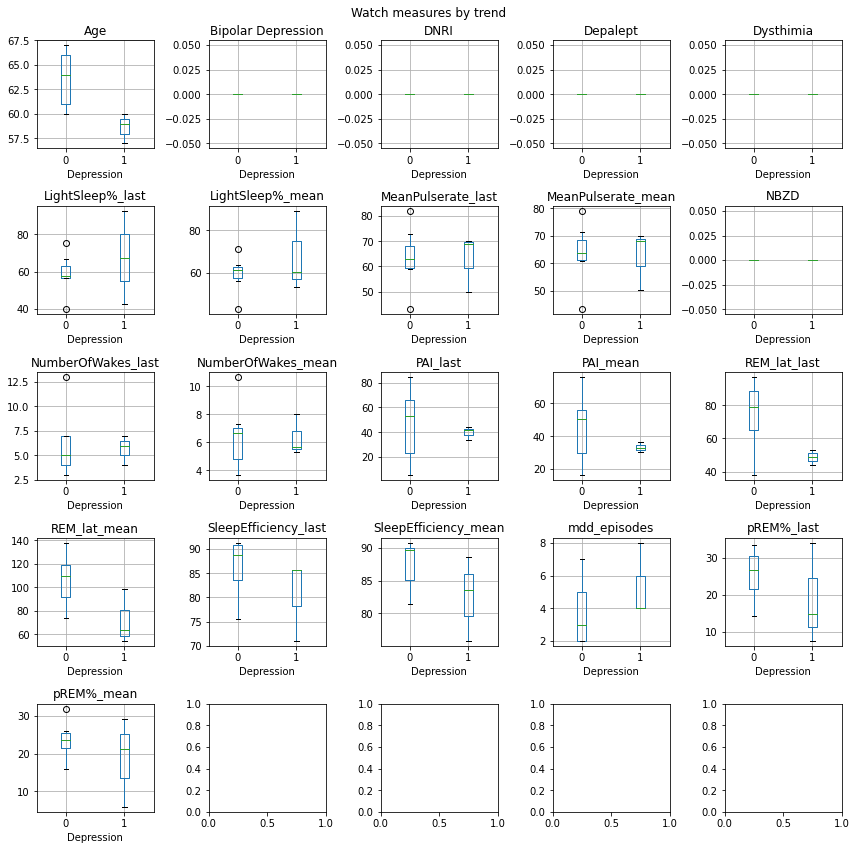

In [45]:

fig, axs = plt.subplots(5,5, figsize=(12,12))


for i,ax in enumerate(axs.flat):
    if i<21:
        col=con_vars[i]
        merged.boxplot(column = [col], # specify columns you wish to analyze
               by = 'Depression',            # specify column by which you wish to group data
               vert = True,        # specify whethere you want vertical or horizontal output
               figsize = (8, 8),
                  ax=ax)   # specify the size of your output
    else:
        pass
    # Show the result
plt.tight_layout()
fig.suptitle('Watch measures by trend')
plt.show()